In [1]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms as T
from torchvision.transforms import functional as F
from skimage import draw,io,segmentation
import time
import sys
import helper_functions as myutils

In [2]:
device=myutils.set_to_gpu()
myutils.setup_seed(0)
myutils.gpu_mem_allocated()
TRAIN_PATH="/scratch_tmp/snk218/stage1_train"
TEST_PATH="/scratch_tmp/snk218/stage1_test"
IMG_CHANNELS=3


No GPU available, using the CPU instead.
Device being used: cpu


Image ID: 50
Dim: h=520 w=348


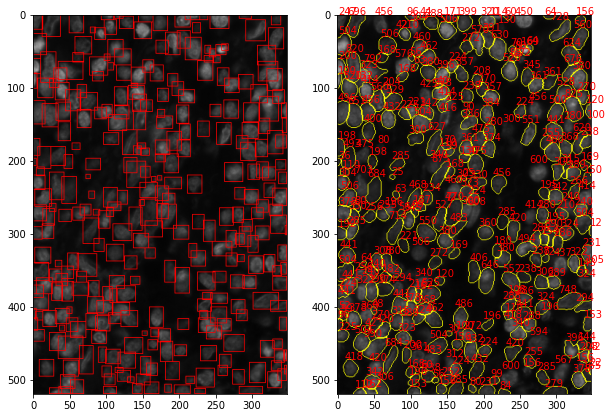

In [71]:
# load an image and mask
# display it
# run length encode the masks
# then, decode again
# display image/mask to see if it is the same...
val_dataset = NucleusDataset(TEST_PATH, train=False) 
image,target=val_dataset[50]
show_data(image,target)

In [61]:
def rle_decode(rle, shape):
    """Decodes an RLE encoded list of space separated
    numbers and returns a binary mask."""
    rle = list(map(int, rle.split()))
    rle = np.array(rle, dtype=np.int32).reshape([-1, 2])
    rle[:, 1] += rle[:, 0]
    rle -= 1
    mask = np.zeros([shape[0] * shape[1]], np.bool)
    for s, e in rle:
        assert 0 <= s < mask.shape[0]
        assert 1 <= e <= mask.shape[0], "shape: {}  s {}  e {}".format(shape, s, e)
        mask[s:e] = 1
    # Reshape and transpose
    mask = mask.reshape([shape[1], shape[0]]).T
    return mask

In [72]:
# open rle test file
# for each unique test image id
# open test image (for shape)
# create folder for mask iamges in the image dir
# for each row (mask)
#   decode and make mask image
#   save mask image to the image dir
import os
import pandas as pd
if(False):
    df = pd.read_csv("/scratch_tmp/snk218/stage1_solution.csv")
    for img_id in df['ImageId'].unique():
        img=io.imread(f"{TEST_PATH}/{img_id}/images/{img_id}.png")
        #os.mkdir(f"{TEST_PATH}/{img_id}/masks")

        cur_df=df[df['ImageId']==img_id]
        if(len(cur_df)==0):
            print(f"No masks for image: {img_id}")
        for row in cur_df.iterrows():
            enc_str=row[1]['EncodedPixels']
            h=row[1]['Height']
            w=row[1]['Width']

            mask=rle_decode(enc_str,(h,w))
            mask=(mask*255).astype('uint8')

            if(mask.shape != img.shape[:2]):
                print(f"Error: mask/image shape mismatch for image {img_id}")
            else:
                io.imsave(f"{TEST_PATH}/{img_id}/masks/{row[0]}.png",mask)
        #break
                  

In [36]:
df = pd.read_csv("/scratch_tmp/snk218/stage1_solution.csv")
df

,ImageId,EncodedPixels,Height,Width,Usage
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31632 6 31886 10 32139 14 32394 15 32649 17 32...,256,256,Public
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 7 50534 10 50788 13 51043 14 51298 16 51...,256,256,Public
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10892 5 11146 9 11401 10 11656 11 11911 13 121...,256,256,Public
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 8 45359 10 45614 12 45869 14 46124 15 46...,256,256,Public
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,38564 4 38819 6 39074 8 39327 11 39582 12 3983...,256,256,Public
...,...,...,...,...,...
4147,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,53498 4 53753 5 53759 1 54009 8 54265 8 54520 ...,256,256,Public
4148,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,56869 4 57124 7 57379 9 57634 11 57890 12 5814...,256,256,Public
4149,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,20376 1 20630 4 20884 7 20893 1 21140 12 21395...,256,256,Public
4150,fe9adb627a6f45747c5a8223b671774791ededf9364f65...,15891 3 16142 11 16398 12 16653 14 16908 15 17...,256,256,Public


In [4]:
# For training: resize image to atleast 512 at min. side and crop to 512x512
MIN_DIM=512 # resize original image to atleast 512 at the minimum side
CROP_DIM=512 # crop to 512x512

In [5]:
# Nucleus data set

# pytorch Mask R CNN model expects an Image (PIL) and, for ground truth targets, a dictionary with these keys:
# boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
# labels (Int64Tensor[N]): the label for each bounding box
# image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
# area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
# iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.
# (optionally) masks (UInt8Tensor[N, H, W]): The segmentation masks for each one of the objects
# One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels.

class NucleusDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True, min_dim=MIN_DIM, crop_dim=CROP_DIM, filter_ids=[]):
        self.root=root # e.g. "stage1_train"
        self.train=train # will resize and random crop the image if True
        self.resize_t=T.Resize(min_dim)
        self.crop_dim=crop_dim

        # a subset of the train set is being used as validation: "filter_ids": the image ids for validation 
        if(len(filter_ids)>0):
            if(train):
                img_ids=next(os.walk(root))[1]
                self.img_ids=list(set(img_ids) - set(filter_ids))
            else:
                self.img_ids=filter_ids
        else:
            self.img_ids=next(os.walk(root))[1]
        
    def __getitem__(self, idx):

        if(type(idx) == type("")):  # Note: don't use this when sending to model on cuda device
          image_id = idx
          idx=self.img_ids.index(image_id)
        else:
          image_id = self.img_ids[idx] # Use numerical index when sending to model on cuda device
          
        # Load image
        img_file = os.path.join(self.root, image_id, "images", image_id+".png")
        image = Image.open(img_file).convert("RGB") # must return PIL image 
        
        # Load masks - masks are a series of binary images - one per nucleus
        mask_files = next(os.walk(os.path.join(self.root, image_id, "masks")))[2]
        masks = np.empty((len(mask_files),image.height,image.width), dtype=bool)
        
        for i,mask_file in enumerate(mask_files):
            masks[i] = imread(os.path.join(self.root, image_id, "masks", mask_file)) != 0
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # Resize and random crop for training - apply to both image and masks
        if self.train:
            # resize image
            image=self.resize_t(image)
            
            # resize masks
            masks=self.resize_t(masks) 
            
            # random crop image
            w, h = image.size  
            tw, th = self.crop_dim,self.crop_dim
            if (w > tw and h > th):
                top = torch.randint(0, h - th + 1, size=(1, )).item()
                left = torch.randint(0, w - tw + 1, size=(1, )).item()
                image = image.crop((left, top, left + tw, top + th))  

                # crop masks
                masks=masks[..., top:top + th, left:left + tw]
            
        # Set up target dictionary return structure that is the format expected 
        # pytorch tutorial training and evalutation scripts will work with this format
            
        # get bbox coords for each mask
        boxes = []
        rr = []
        for i in range(len(masks)):
            pos = np.where(masks[i])
            if(len(pos[0]) > 0):
                # filter if mask not in the image (since it was cropped)
                # NOTE: the bbox expected is (x0,y0,x-max,y-max)
                # NOT usual numpy way!
                xmin = np.min(pos[1]) 
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                
                # filter if mask bbox length or width == 1
                if(xmax-xmin > 0 and ymax-ymin > 0):
                    boxes.append([xmin, ymin, xmax, ymax])
                    rr.append(i)
                
        num_objs = len(rr)

        if(num_objs==0):
            return None

        masks = masks[rr,:]

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
        masks = torch.as_tensor(masks, dtype=torch.uint8) 
        idx=torch.as_tensor(idx,dtype=torch.int64)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd: "instances with iscrowd==True wil be ignored during evaluation"
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes        # bounding boxes of the nuclei masks
        target["labels"] = labels      # labels, an array of ones, since we only have one class (nucleus)
        target["masks"] = masks        # pixel coordinates of the nuclei masks
        target["image_id"] = idx       # image id: numerical index
        target["area"] = area          # mask areas
        target["iscrowd"] = iscrowd    # always set to False (?)

        image = F.to_tensor(image)

        return image, target

    def __len__(self):
        return len(self.img_ids)
    
def nucleus_collate_fn(batch):
    batch = filter(lambda x:x is not None, batch)
    return tuple(zip(*batch))        

In [6]:
def show_data(img,label,model_output=False):

    if(isinstance(img, torch.Tensor)):
        img_=np.array(F.to_pil_image(img,mode="RGB"))
    else:
        img_=np.array(img)
  
    if(model_output):
        fig,ax=plt.subplots(1,3,figsize=(20,30))
    else:
        fig,ax=plt.subplots(1,2,figsize=(10,20))

    out_img=img_.copy()
    
    if(len(label['masks'])>0):
        labeled_img=np.zeros(label['masks'][0].squeeze().detach().numpy().shape, dtype='uint8') 
        
        if(model_output):
            for i,bbox in enumerate(label["boxes"]):
                if(label['scores'][i]>=0.5):
                    bbox_=[int(x.item()) for x in bbox]
                    mask=(label['masks'][i].squeeze().detach().numpy()>0.5).astype('uint8')

                    #print(f"{i}: {bbox}")
                    

                    if((i+1)<256): 
                        # check first if this mask is overlaping a previous mask: if so, skip it.
                        # is this normal for MaskRCNN to output overlapping masks?
                        if np.max(mask*labeled_img)>0:
                            pass
                            #print("Overlap")
                        else:
                            labeled_img = labeled_img+(mask*(i+1))

                            # Note!  bboxes are in x0,y0,xmax,ymax format 
                            rr,cc = draw.rectangle_perimeter((bbox_[1],bbox_[0]), 
                                                      extent=(bbox_[3]-bbox_[1],
                                                              bbox_[2]-bbox_[0]),
                                                      shape=out_img.shape)
                    
                            out_img[rr, cc, :] = [255,0,0]
                        
                    #if(i >= 2): break # ********* # <------
                    
                else:
                    break # scores are sorted high to low
            marked=segmentation.mark_boundaries(img_,labeled_img,) 
        else:
            for i,mask in enumerate(label['masks']):
                if((i+1)<256):
                    labeled_img = labeled_img+(mask.detach().numpy()*(i+1))
            marked=segmentation.mark_boundaries(img_,labeled_img,) 

            for bbox in label["boxes"]:
                bbox_=[int(x.item()) for x in bbox]

                # Note!  bboxes are in x0,y0,xmax,ymax format 
                rr, cc = draw.rectangle_perimeter((bbox_[1],bbox_[0]), 
                                                  extent=(bbox_[3]-bbox_[1],
                                                          bbox_[2]-bbox_[0]),
                                                  shape=out_img.shape)
                out_img[rr, cc, :] = [255,0,0]
    else:
        print("Alert: No masked nuclei in image.")
        marked=out_img
        
    if(model_output):
        print(f"Dim: h={img_.shape[0]} w={img_.shape[1]}")
        ax[0].imshow(out_img)
        ax[1].imshow(labeled_img)
        ax[2].imshow(marked)
    else:
        print(f"Image ID: {label['image_id']}") 
        print(f"Dim: h={img_.shape[0]} w={img_.shape[1]}")
        ax[0].imshow(out_img)
        ax[1].imshow(marked)
    
    if(not model_output):
        for bbox,area in zip(label["boxes"],label['area']):
            bbox_=[int(x.item()) for x in bbox]
            ax[1].text(bbox_[0],bbox_[1],str(int(area.item())), color='red')


In [13]:
dataset = NucleusDataset(TRAIN_PATH, train=True) 
data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=4, 
                                          shuffle=True, 
                                          #num_workers=2,
                                          collate_fn=nucleus_collate_fn)
val_dataset = NucleusDataset(TRAIN_PATH, train=False) 
val_data_loader = torch.utils.data.DataLoader(val_dataset, 
                                          batch_size=4, 
                                          shuffle=True, 
                                          #num_workers=2,
                                          collate_fn=nucleus_collate_fn)

In [32]:
images,targets = next(iter(data_loader))
print(len(images))
print(len(targets))

4
4


Image ID: 237
Dim: h=512 w=512


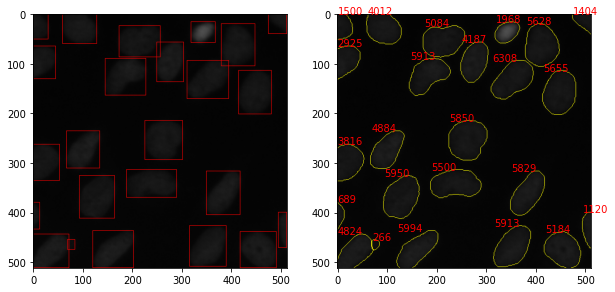

In [33]:
show_data(images[0],targets[0])

In [34]:
# images is a list of tensors of C,H,W - need to convert to numpy, H,W,C
images=[(np.transpose(x.numpy(), (1, 2, 0))*255).astype('uint8') for x in images]

In [35]:
images[0].shape

(512, 512, 3)

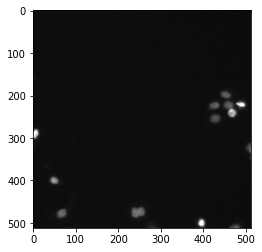

In [36]:
plt.imshow(images[3])

In [37]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

#for batch_idx in range(len(images)):
    # 'images' should be either a 4D numpy array of shape (N, height, width, channels)
    # or a list of 3D numpy arrays, each having shape (height, width, channels).
    # Grayscale images must have shape (height, width, 1) each.
    # All images must have numpy's dtype uint8. Values are expected to be in
    # range 0-255.
    #images = load_batch(batch_idx)
    
images_aug = seq(images=images)
#train_on_images(images_aug)

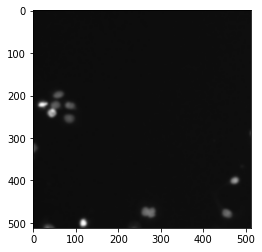

In [38]:
plt.imshow(images_aug[3])

In [39]:
np.stack(targets[0]['masks'],axis=-1).shape

(512, 512, 24)

In [40]:
images[0].shape

(512, 512, 3)

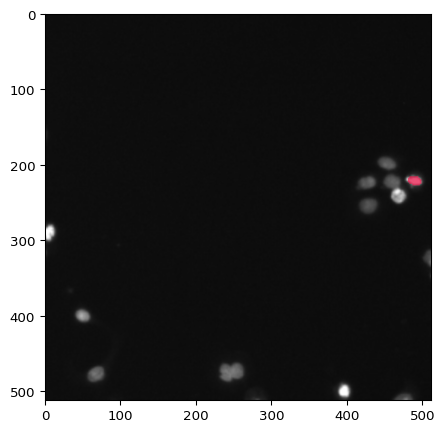

In [50]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug as ia
#arr can have shape (H,W,C) with C>1. That is useful for e.g. stacked boolean masks.

# convert array to SegmentationMapsOnImage instance
segmap=np.stack(targets[img_idx]['masks'],axis=-1)
segmap = SegmentationMapsOnImage(segmap, shape=images[img_idx].shape)

ia.imshow(segmap.draw_on_image(images[img_idx])[0])

In [53]:


#seq = iaa.Sequential([
#    iaa.CoarseDropout(0.1, size_percent=0.2),
#    iaa.Affine(rotate=(-30, 30)),
#    iaa.ElasticTransformation(alpha=10, sigma=1)
#])


seq = iaa.SomeOf((0, 2), [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
               iaa.Affine(rotate=180),
               iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.5)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

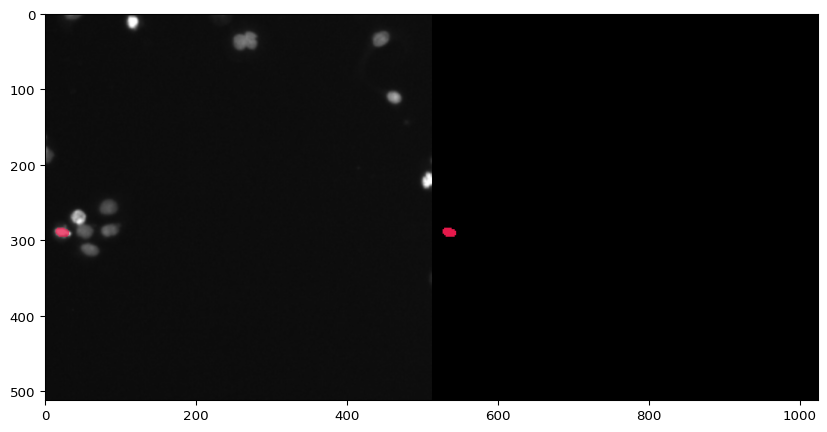

In [54]:
img_idx=3

segmap=np.stack(targets[img_idx]['masks'],axis=-1)
segmap = SegmentationMapsOnImage(segmap, shape=images[img_idx].shape)

image_aug, segmap_aug = seq(image=images[img_idx], segmentation_maps=segmap)

# visualize
ia.imshow(np.hstack([
    segmap_aug.draw_on_image(image_aug)[0],  # show blend of (augmented) image and segmentation map
    segmap_aug.draw()[0]  # show only the augmented segmentation map
]))

In [44]:
arr = segmap.arr
arr_int = segmap.get_arr()

print("[segmap.arr]       Shape:", arr.shape, "dtype:", arr.dtype)
print("[segmap.get_arr()] Shape:", arr_int.shape, "dtype:", arr_int.dtype)

[segmap.arr]       Shape: (512, 512, 24) dtype: int32
[segmap.get_arr()] Shape: (512, 512, 24) dtype: uint8


In [66]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
def get_model_instance_segmentation(num_classes):
    
    # ToDo: change any of these?
    #min_size (int): minimum size of the image to be rescaled before feeding it to the backbone
    #max_size (int): maximum size of the image to be rescaled before feeding it to the backbone
    #image_mean (Tuple[float, float, float]): mean values used for input normalization.
    #image_std (Tuple[float, float, float]): std values used for input normalization.
    #They are generally the std values of the dataset on which the backbone has been trained on
    #
    # min_size=(800,)
    # maxsize=1333
    # mean=[0.485, 0.456, 0.406]
    # std=[0.229, 0.224, 0.225]
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    # ToDo - figure this out...
    # I think, smaller anchor scales than the default will help for nuclei of smaller sizes
    #anchor_generator = AnchorGenerator(sizes=((8, 16, 32, 64, 128),),aspect_ratios=((0.5, 1.0, 2.0),))

            
    return model


In [67]:
model = get_model_instance_segmentation(2) # 1 class (nucleus) + background
#model.roi_heads.nms_thresh=0.3

#print(model.rpn.anchor_generator.sizes)
#print(model.rpn.anchor_generator.aspect_ratios)
#model


In [15]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
model.train()
output = model(images,targets)   # Returns losses given images and ground truth target masks
output

In [71]:
images,targets = next(iter(data_loader))
print(len(images))
print(len(targets))
images[0]

4
4


tensor([[[0.0157, 0.0118, 0.0118,  ..., 0.0118, 0.0078, 0.0118],
         [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0118],
         [0.0157, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0196, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0196],
         [0.0235, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0275, 0.0275, 0.0235]],

        [[0.0157, 0.0118, 0.0118,  ..., 0.0118, 0.0078, 0.0118],
         [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0118],
         [0.0157, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0196, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0196],
         [0.0235, 0.0196, 0.0196,  ..., 0.0235, 0.0235, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0275, 0.0275, 0.0235]],

        [[0.0157, 0.0118, 0.0118,  ..., 0.0118, 0.0078, 0.0118],
         [0.0157, 0.0118, 0.0118,  ..., 0.0078, 0.0078, 0.0118],
         [0.0157, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.

In [17]:
model.eval()
predictions = model(images)  
predictions[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [18]:
predictions[0]['masks'].shape

torch.Size([100, 1, 512, 512])

Dim: h=512 w=512


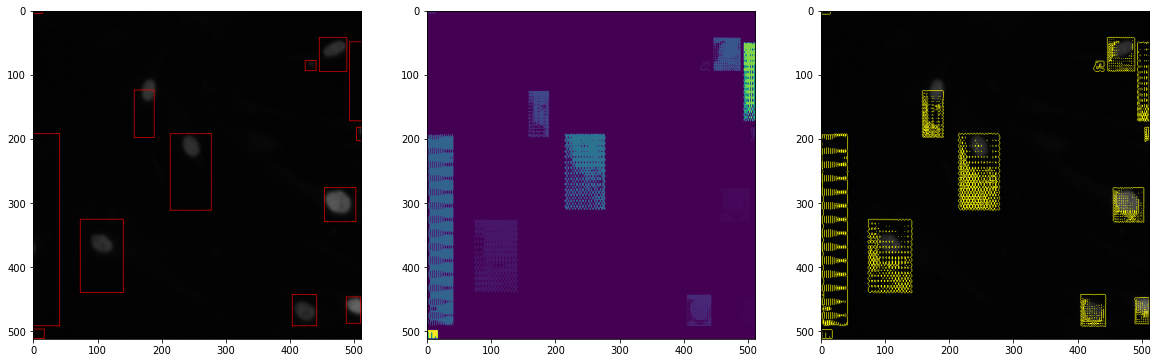

In [19]:
show_data(images[0], predictions[0], model_output=True)

Image ID: 74
Dim: h=256 w=256


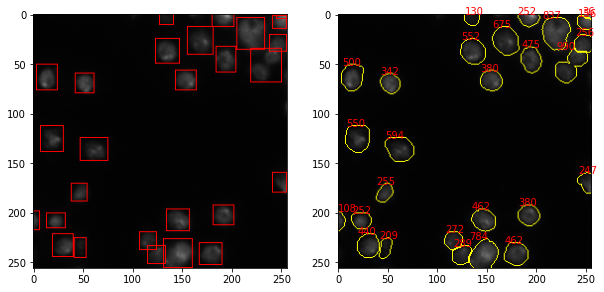

In [20]:
# test metric functions: IoU, Average Precision, etc.

# load an image as its ground truth
test_image_id='0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
dataset = NucleusDataset(TRAIN_PATH, train=False, transforms=get_transform(train=False))
test_image,test_labels=dataset[test_image_id]
show_data(test_image,test_labels)

Image ID: 0
Dim: h=256 w=256


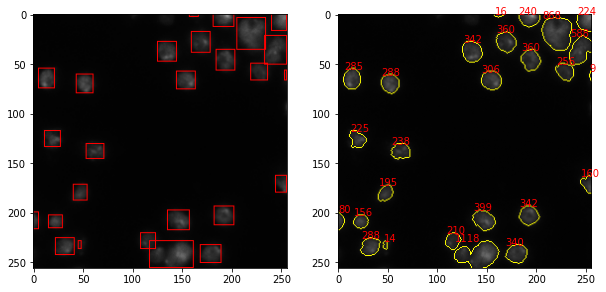

In [21]:
# test "prediction" image - with masks that were made by simple thresholding
TEST_PROP_PATH="/scratch_tmp/snk218/test_proposal"
test_image_id_prop='_0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9'
dataset_prop = NucleusDataset(TEST_PROP_PATH, train=False, transforms=get_transform(train=False))
test_image_prop,test_labels_prop=dataset_prop[test_image_id_prop]
show_data(test_image_prop,test_labels_prop)

In [22]:
gt_boxes = myutils.rearrange_boxes(test_labels['boxes'].numpy()) # (#-instances,4)
gt_masks = np.stack(test_labels['masks'],axis=-1) # (H,W,#-instances)
gt_class_ids=test_labels['labels'].numpy() # (#-instances)

pred_boxes = myutils.rearrange_boxes(test_labels_prop['boxes'].numpy()) # (#-pred-instances,4)
pred_masks=np.stack(test_labels_prop['masks'],axis=-1) # (H,W,#-pred-instances)
pred_class_ids=test_labels_prop['labels'].numpy() # (#-pred-instances)
pred_scores=np.ones(len(pred_boxes))*0.9 # (#-pred-instances)

'''
Input format:

(N = number of predicted objects)
pred_boxes: [N, (y1, x1, y2, x2)] detection bounding boxes
pred_class_ids: [N] int class IDs
pred_scores: [N] float probability scores for the class IDs
pred_masks: [H, W, N] instance binary masks

*M = number of g.t. objects)
gt_class_id              shape: (M,)                 
gt_bbox                  shape: (M, 4)               
gt_mask                  shape: (H, W, M)             
'''     

mAP,precisions,recalls,overlaps=myutils.compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5)

'''Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    '''

print(mAP)
print(precisions)
print(recalls)

myutils.compute_ap_range(gt_boxes, gt_class_ids, gt_masks,
                     pred_boxes, pred_class_ids, pred_scores, pred_masks,
                     iou_thresholds=None, verbose=1)

0.544566542769854
[1.         1.         0.78571429 0.78571429 0.78571429 0.78571429
 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429 0.78571429
 0.78571429 0.78571429 0.78571429 0.73333333 0.73076923 0.73076923
 0.73076923 0.73076923 0.73076923 0.73076923 0.73076923 0.73076923
 0.73076923 0.73076923 0.73076923 0.        ]
[0.         0.03703704 0.03703704 0.07407407 0.07407407 0.07407407
 0.11111111 0.14814815 0.18518518 0.22222222 0.25925925 0.2962963
 0.33333334 0.37037036 0.4074074  0.4074074  0.4074074  0.44444445
 0.44444445 0.48148149 0.51851851 0.51851851 0.55555558 0.5925926
 0.62962961 0.66666669 0.7037037  1.        ]
AP @0.50:	 0.545
AP @0.55:	 0.480
AP @0.60:	 0.340
AP @0.65:	 0.259
AP @0.70:	 0.148
AP @0.75:	 0.095
AP @0.80:	 0.039
AP @0.85:	 0.015
AP @0.90:	 0.002
AP @0.95:	 0.000
AP @0.50-0.95:	 0.192


0.19219707111996678

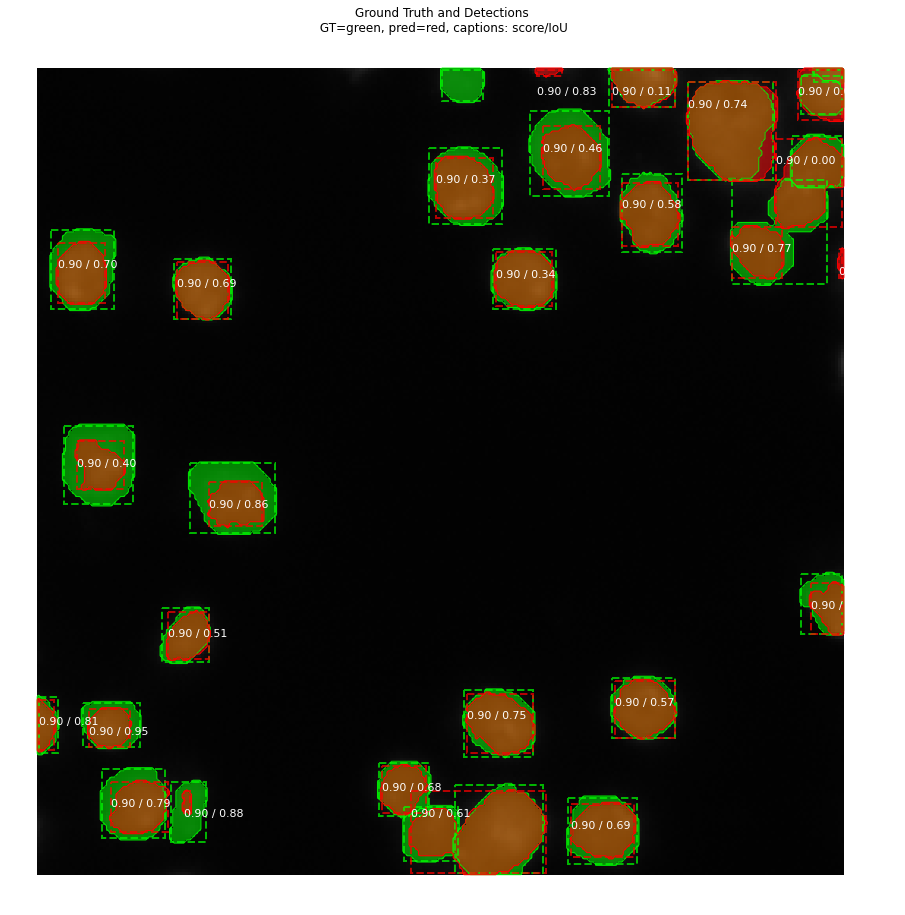

In [23]:
class_names=['bk','nucleus']
myutils.display_differences(np.array(F.to_pil_image(test_image,mode="RGB")),
                        gt_boxes, gt_class_ids, gt_masks,
                        pred_boxes, pred_class_ids, pred_scores, pred_masks,
                        class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5)

In [33]:
# BELOW IS TAKEN FROM 3rd place entry in competition: "DeepRetina" (https://github.com/Gelu74/DSB_2018)
# "The dataset doesn't have a standard train/val split, so I picked a variety of images to surve as a validation set."
VAL_IMAGE_IDS = [
    "0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2",
    "92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7",
    "1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f",
    "c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339",
    "8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b",
    "60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff",
    "da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844",
    "9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32",
    "1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df",
    "97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034",
    "e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0",
    "f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81",
    "0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1",
    "3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90",
    "ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716",
    "bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676",
    "e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b",
    "947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050",
    "cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd",
    "f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3",
    "4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06",
    "f73e37957c74f554be132986f38b6f1d75339f636dfe2b681a0cf3f88d2733af",
    "a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4",
    "cab4875269f44a701c5e58190a1d2f6fcb577ea79d842522dcab20ccb39b7ad2",
    "8ecdb93582b2d5270457b36651b62776256ade3aaa2d7432ae65c14f07432d49",
]